# CAPSTONE

**Identifying Fake News**

**Project Overview**

The goal of this project is to create a fake new identification system using natural language processing (NLP). My data set consists of over 40 thousand articles obtained from Kaggle. A variety of machine learning models have been used to generate the best results.

**Business Case**

Over the course of the past decade, the amount of fake news being shared on social media has seen a dramatic increase. According to NewsGuard, "in 2019, 8 percent of engagement with the 100 top-performing news sources on social media was dubious. In 2020, that number more than doubled to 17 percent" ([Vox](https://www.vox.com/policy-and-politics/2020/12/22/22195488/fake-news-social-media-2020)). In 2021, the Daily Wire, the outlet founded by right-wing comentator Ben Shapiro, was the most popular news platform on Facebook.

From casting doubts on the results of the 2020 presidential election to spreading misinformation about the COVID vaccine, fake news is causing real damage to our society.

Because the main source of fake news is social media sites, such as Facebook and Twitter, I set out to produce a fake news identification system that can be used by social media companies to filter out minsinformation. A altnerative use of this system could be a web app with which users can verify the authenticity of a story themselves.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
import string
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import spacy
import re
from sklearn.dummy import DummyClassifier
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
import requests
from os import path
import pickle
from nltk.util import ngrams
import nltk, re, string, collections

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acumu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import CSVs and Data Cleaning

**Spacy Preprocessing Functions**

In [2]:
# Import list of stopwords from SpaCy
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [3]:
# Create a function to tokenize the text of the articles
punctuation = [*string.punctuation , *[str(x) for x in list(range(0,10))]]
nlp = spacy.load('en_core_web_sm')
def normalize(text):
    text = ''.join([x for x in text if x not in punctuation])
    toks = nlp(text)
    toks = [word.lemma_.lower().strip() for word in toks if word.pos_ != 'PRON']
    toks = [word for word in toks if word not in stop_words]
    return ' '.join(toks)

**Real News**

In [4]:
# Import real news articles
df_true = pd.read_csv('True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# Create target column
df_true = df_true.assign(status = 'Real')
df_true.head()

,title,text,subject,date,status
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


In [6]:
# Remove city names and news sources from 'text' column
df_true['text']=df_true['text'].str.extract(r'(?<=\-\s)(.*)')

In [7]:
df_true.head()

,title,text,subject,date,status
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",Real


In [8]:
df_true.shape

(21417, 5)

In [9]:
# Check for missing data
df_true.isnull().sum()

title       0
text       21
subject     0
date        0
status      0
dtype: int64

In [10]:
# Drop articles missing text
df_true.dropna(inplace=True)

In [11]:
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
status     0
dtype: int64

In [ ]:
# Apply tokenization function to the real articles. Create a new column for the processed articles
df_true['processed_articles'] = df_true['text'].map(lambda x: normalize(x))

In [ ]:
list(df_true.processed_articles)

In [ ]:
# Save the new processed data frame
pickle_out = open('pickled_files/df_spacy_true.pickle',"wb")
pickle.dump(df_true, pickle_out)
pickle_out.close()

In [12]:
infile = open('pickled_files/df_spacy_true.pickle','rb')
df_true = pickle.load(infile)
infile.close()

In [13]:
true_text = df_true.processed_articles

In [14]:
df_true.head()

,title,text,subject,date,status,processed_articles
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",Real,head conservative republican faction congress ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",Real,transgender people allow time enlist military ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",Real,special counsel investigation link russia pres...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",Real,trump campaign adviser george papadopoulos tel...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",Real,president donald trump postal service friday c...


In [15]:
str(true_text)

'0        head conservative republican faction congress ...\n1        transgender people allow time enlist military ...\n2        special counsel investigation link russia pres...\n3        trump campaign adviser george papadopoulos tel...\n4        president donald trump postal service friday c...\n                               ...                        \n21412    nato ally tuesday welcome president donald tru...\n21413    lexisnexis provider legal regulatory business ...\n21414    shadow disuse sovietera factory minsk street l...\n21415    vatican secretary state cardinal pietro paroli...\n21416    indonesia buy  sukhoi fighter jet worth  billi...\nName: processed_articles, Length: 21396, dtype: object'

In [16]:
# Create a list of all of the tokenized words
true_list = []
for x in true_text:
    true_list.append(x)

In [17]:
true_list

['head conservative republican faction congress vote month huge expansion national debt pay tax cut " fiscal conservative " sunday urge budget restraint  sharp pivot way republicans representative mark meadows speak cbs \' " face nation " draw hard line federal spending lawmaker brace battle january return holiday wednesday lawmaker begin try pass federal budget fight likely link issue immigration policy november congressional election campaign approach republicans seek control congress president donald trump republicans want big budget increase military spending democrats want proportional increase nondefense " discretionary " spending program support education scientific research infrastructure public health environmental protection " trump administration willing \' increase nondefense discretionary spending   percent \' " meadow chairman small influential house freedom caucus program " democrats need government pay raise   percent fiscal conservative rationale  eventually run people

In [18]:
len(str(true_list))

32359425

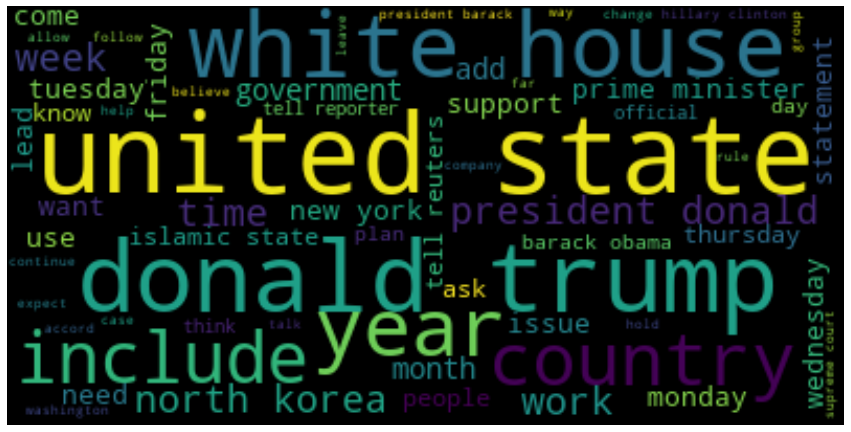

In [19]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(true_list))

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Create a new list of stopwords
stopwords = ['``', 's', 'c', "'", ",", "t", "l", 'j', '...', ":", '0', '1', '2', 'couldn', 'wouldn', 'isn', 'aren', 'shouldn']
# Create a new tokenized list to use in the frequency distribution tables
true_tokenized_word = nltk.word_tokenize(str(true_list))

In [21]:
# Iterate through new tokenized list and remove additional stopwords.
true_tokenized_word = [word for word in true_tokenized_word if word not in stopwords]

In [22]:
# Create frequency distribution for the words in the real articles
true_fdist=nltk.FreqDist(true_tokenized_word)

In [23]:
print(true_fdist.most_common(20))

[('trump', 53953), ('president', 24744), ('state', 24139), ('government', 19384), ('year', 19200), ('house', 16618), ('new', 15667), ('tell', 15494), ('people', 15211), ('party', 14945), ('united', 14787), ('republican', 14617), ('official', 14457), ('country', 13965), ('election', 13854), ('states', 12316), ('include', 12154), ('campaign', 11592), ('group', 11053), ('vote', 10886)]


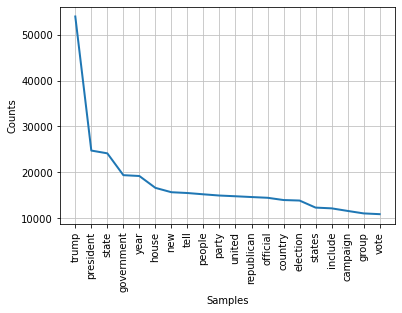

In [82]:
# Plot frequency distribution for the 20 most common words
true_fdist.plot(20)
plt.show()

In [25]:
# Get a list of all the bi-grams
true_bigrams = ngrams(true_tokenized_word, 2)

In [26]:
# List 20 most common bigrams
true_bigrams_freq = collections.Counter(true_bigrams)
true_bigrams_freq.most_common(20)

[(('united', 'states'), 11844),
 (('donald', 'trump'), 9816),
 (('white', 'house'), 8121),
 (('north', 'korea'), 5527),
 (('president', 'donald'), 4270),
 (('prime', 'minister'), 4100),
 (('new', 'york'), 3620),
 (('tell', 'reuters'), 3515),
 (('islamic', 'state'), 3321),
 (('barack', 'obama'), 3317),
 (('tell', 'reporter'), 3242),
 (('president', 'barack'), 2517),
 (('hillary', 'clinton'), 2426),
 (('supreme', 'court'), 2365),
 (('trump', 'administration'), 2343),
 (('secretary', 'state'), 2121),
 (('national', 'security'), 2112),
 (('house', 'representatives'), 2048),
 (('presidential', 'election'), 2015),
 (('united', 'nations'), 1970)]

In [27]:
true_bigram_fdist=nltk.FreqDist(true_bigrams_freq)

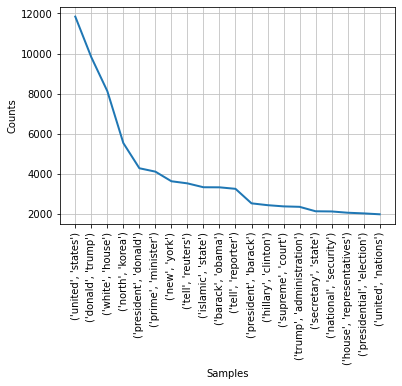

In [28]:
true_bigram_fdist.plot(20)
plt.show()

In [29]:
# Get a list of all the tri-grams
true_trigrams = ngrams(true_tokenized_word, 3)

In [30]:
# List 20 most common tri-grams
true_trigrams_freq = collections.Counter(true_trigrams)
true_trigrams_freq.most_common(20)

[(('president', 'donald', 'trump'), 4208),
 (('president', 'barack', 'obama'), 2510),
 (("'president", 'donald', 'trump'), 1558),
 (('respond', 'request', 'comment'), 832),
 (('president', 'vladimir', 'putin'), 764),
 (('state', 'rex', 'tillerson'), 671),
 (('george', 'w', 'bush'), 662),
 (('national', 'security', 'adviser'), 625),
 (('speaker', 'paul', 'ryan'), 606),
 (('leader', 'mitch', 'mcconnell'), 568),
 (('un', 'security', 'council'), 552),
 (('democratic', 'president', 'barack'), 545),
 (('chancellor', 'angela', 'merkel'), 539),
 (('secretary', 'state', 'rex'), 538),
 (('prime', 'minister', 'theresa'), 536),
 (('presidentelect', 'donald', 'trump'), 532),
 (('speak', 'condition', 'anonymity'), 519),
 (('new', 'york', 'times'), 516),
 (('russian', 'president', 'vladimir'), 509),
 (('white', 'house', 'official'), 502)]

In [31]:
true_trigram_fdist=nltk.FreqDist(true_trigrams_freq)

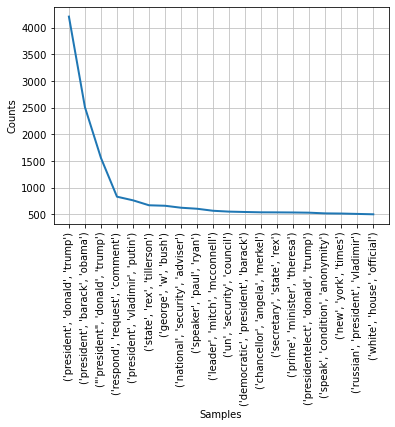

In [32]:
true_trigram_fdist.plot(20)
plt.show()

**Fake News**

In [33]:
# Import Fake news articles
df_fake = pd.read_csv('Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [34]:
# Create target column
df_fake = df_fake.assign(status = 'Fake')
df_fake.head()

,title,text,subject,date,status
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [35]:
df_fake.shape

(23481, 5)

In [36]:
# Check for missing data
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
status     0
dtype: int64

In [ ]:
# Apply tokenization function to the real articles. Create a new column for the processed articles
df_fake['processed_articles'] = df_fake['text'].map(lambda x: normalize(x))

In [ ]:
list(df_fake.processed_articles)

In [ ]:
# Save the new processed data frame
pickle_out = open('pickled_files/df_spacy_fake.pickle',"wb")
pickle.dump(df_fake, pickle_out)
pickle_out.close()

In [37]:
infile = open('pickled_files/df_spacy_fake.pickle','rb')
df_fake = pickle.load(infile)
infile.close()

In [38]:
fake_text = df_fake.processed_articles

In [39]:
# Create a list of all of the tokenized words
fake_list = []
for x in fake_text:
    fake_list.append(x)

In [40]:
len(str(fake_list))

36692492

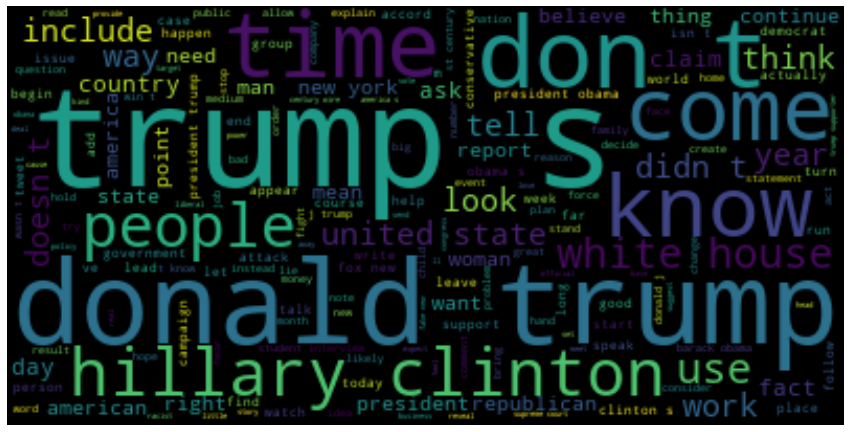

In [41]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(fake_list))

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
# Create a new tokenized list to use in the frequency distribution tables
fake_tokenized_word = nltk.word_tokenize(str(fake_list))

In [43]:
# Iterate through new tokenized list and remove additional stopwords.
fake_tokenized_word = [word for word in fake_tokenized_word if word not in stopwords]

In [44]:
# Create frequency distribution for the words in the real articles
fake_fdist = nltk.FreqDist(fake_tokenized_word)

In [45]:
print(fake_fdist.most_common(20))

[('trump', 73656), ('people', 25945), ('president', 25760), ('like', 18317), ('clinton', 17984), ('obama', 17613), ('state', 17403), ('know', 16247), ('donald', 15813), ('time', 15079), ('year', 15049), ('tell', 14510), ('new', 14147), ('news', 14089), ('come', 13587), ('hillary', 13281), ('white', 13026), ('think', 12272), ('want', 12032), ('use', 11999)]


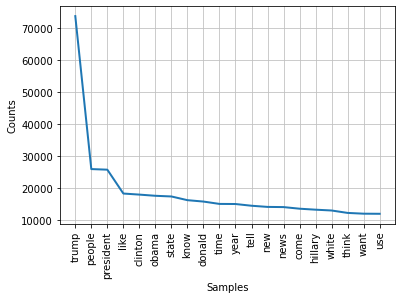

In [46]:
# Plot frequency distribution for the 20 most common words
fake_fdist.plot(20)
plt.show()

In [47]:
# Get a list of all the bi-grams
fake_bigrams = ngrams(fake_tokenized_word, 2)

In [48]:
# List 20 most common bi-grams
fake_bigrams_freq = collections.Counter(fake_bigrams)
fake_bigrams_freq.most_common(20)

[(('donald', 'trump'), 13901),
 (('hillary', 'clinton'), 6554),
 (('white', 'house'), 6230),
 (('united', 'states'), 6143),
 (('new', 'york'), 4142),
 (('president', 'obama'), 3731),
 (('president', 'trump'), 3527),
 (('fox', 'news'), 3101),
 (('barack', 'obama'), 2176),
 (('century', 'wire'), 1926),
 (('trump', 'supporter'), 1885),
 (('trump', 'campaign'), 1789),
 (('fake', 'news'), 1771),
 (('supreme', 'court'), 1751),
 (('trump', 'realdonaldtrump'), 1694),
 (('obama', 'administration'), 1643),
 (('national', 'security'), 1629),
 (('social', 'medium'), 1597),
 (('police', 'officer'), 1564),
 (('law', 'enforcement'), 1552)]

In [49]:
fake_ngram_fdist=nltk.FreqDist(fake_bigrams_freq)

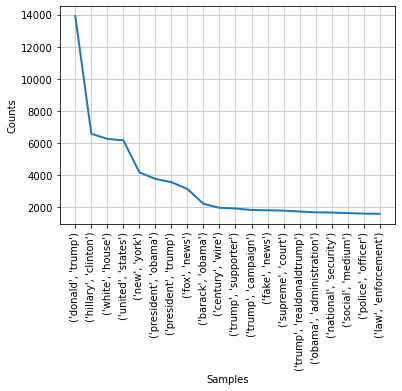

In [50]:
fake_ngram_fdist.plot(20)
plt.show()

In [51]:
# Get a list of all the tri-grams
fake_trigrams = ngrams(fake_tokenized_word, 3)

In [52]:
# List 20 most common tri-grams
fake_trigrams_freq = collections.Counter(fake_trigrams)
fake_trigrams_freq.most_common(20)

[(('donald', 'trump', 'realdonaldtrump'), 1692),
 (('new', 'york', 'times'), 1458),
 (('st', 'century', 'wire'), 1225),
 (('news', 'st', 'century'), 941),
 (('president', 'donald', 'trump'), 915),
 (('president', 'united', 'states'), 901),
 (('president', 'barack', 'obama'), 832),
 (('black', 'life', 'matter'), 808),
 (('subscribe', 'member', 'wiretv'), 737),
 (('video', 'screen', 'capture'), 728),
 (('image', 'video', 'screen'), 697),
 (("'st", 'century', 'wire'), 679),
 (('images', "'donald", 'trump'), 619),
 (('new', 'york', 'city'), 596),
 (('george', 'w', 'bush'), 559),
 (('director', 'james', 'comey'), 479),
 (('wire', 'subscribe', 'member'), 465),
 (('fbi', 'director', 'james'), 458),
 (('image', 'screen', 'capture'), 446),
 (('affordable', 'care', 'act'), 391)]

In [53]:
fake_trigram_fdist=nltk.FreqDist(fake_trigrams_freq)

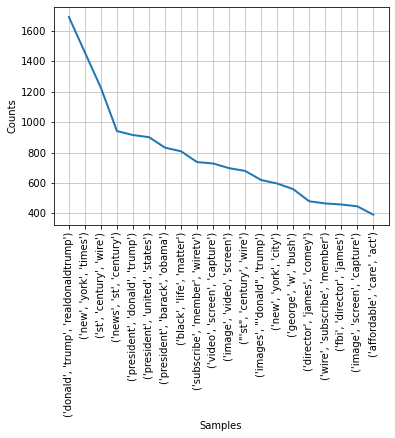

In [54]:
fake_trigram_fdist.plot(20)
plt.show()

**Join data frames**

In [ ]:
# Concatenate the two dataframes
frames = [df_true, df_fake]
df=pd.concat(frames)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
# Shuffle rows
df = df.sample(frac = 1)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Check for missing data
df.isnull().sum()

## Train test split

In [ ]:
# Separate features and labels 
X = df['processed_articles']
y = df.status

# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Modeling

### Dummy Classifier

In [ ]:
# Run dummy classifier to get baseline prediction
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)

In [ ]:
# Create function to evaluate model and display confusion matrix
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    print(classification_report(y, y_pred))
    
    plot_confusion_matrix(model, X, y, cmap='Blues', xticks_rotation='vertical')

In [ ]:
evaluate_model(dummy_clf, X, y)

### Logistic Regression

**Simple Logistic Regression Pipeline** 

In [ ]:
# Create a simple logistic regression pipeline including model and vectorizer 
lr_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [ ]:
# Fit the pipeline to the training data
lr_pipeline.fit(X_train, y_train)

In [ ]:
pd.DataFrame(lr_pipeline.predict(X_test)).value_counts()

In [ ]:
evaluate_model(lr_pipeline, X_train, y_train)

In [ ]:
evaluate_model(lr_pipeline, X_test, y_test)

**Logistic Regression Pipeline with hyperparameters tuned**

In [ ]:
# Create a logistic regression pipeline including a tuned model and vectorizer
lr_pipeline2 = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=.9, ngram_range = (1, 2))),
    ('lr', LogisticRegression(solver='saga', 
                              max_iter = 500, 
                              C=1, 
                              penalty='l2', 
                              verbose=1, 
                              n_jobs=-1,
                              random_state=42))
])

In [ ]:
# Fit the model to the training data
lr_pipeline2.fit(X_train, y_train)

In [ ]:
pd.DataFrame(lr_pipeline2.predict(X_test)).value_counts()

In [ ]:
evaluate_model(lr_pipeline2, X_train, y_train)

In [ ]:
evaluate_model(lr_pipeline2, X_test, y_test)

**Logistic Regression Pipeline with Gridsearch**

In [ ]:
# Create a logistic regression pipeline including a tuned model and vectorizer
lr_pipeline_3 = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression(class_weight='balanced', solver='saga', random_state=42))
])

In [ ]:
# Define gridsearch parameters
lr_param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [500, 1000],
    'vectorizer__max_df': np.linspace(.7,1,5),
    'vectorizer__min_df': [10],
    'vectorizer__ngram_range': [(1, 2)]
}

In [ ]:
# Combine logistic regression pipeline with gridsearch
lr_grid = GridSearchCV(lr_pipeline_3, 
                       lr_param_grid,
                       cv=5,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

In [ ]:
# Fit pipeline with gridsearch to the training data
lr_grid.fit(X_train, y_train)

In [ ]:
# Display best parameters
lr_grid.best_params_

In [ ]:
evaluate_model(lr_grid, X_train, y_train)

In [ ]:
evaluate_model(lr_grid, X_test, y_test)

In [ ]:
lr_grid_model = lr_grid.best_estimator_.fit(X_train, y_train)

In [ ]:
# Save the model
pickle_out = open('pickled_files/lr_grid_model.pickle',"wb")
pickle.dump(lr_grid_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/lr_grid_model.pickle','rb')
lr_grid_model = pickle.load(infile)
infile.close()

### Naive Bayes

**Naive Bayes Pipeline**

In [ ]:
# Create a tuned multinomial naive bayes pipeline including a model and vectorizer
nb_pipeline = imbPipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.9)),
    ('nb', MultinomialNB())
])

In [ ]:
# Fit the pipeline to the training data
nb_pipeline.fit(X_train, y_train)

In [ ]:
evaluate_model(nb_pipeline, X_train, y_train)

In [ ]:
evaluate_model(nb_pipeline, X_test, y_test)

**Naive Bayes Pipeline with Gridsearch**

In [ ]:
# Create a  multinomial naive bayes pipeline including a model and vectorizer
nb_pipeline_2 = imbPipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [ ]:
# Define gridsearch parameters
nb_param_grid = {
    'nb__alpha': np.linspace(0, 4, 10),
    'vectorizer__max_df': np.linspace(.8,1,5),
    'vectorizer__min_df': [10],
    'vectorizer__norm': ['l1', 'l2']
    }

In [ ]:
# Combine Naive Bayes pipeline with gridsearch
nb_grid = GridSearchCV(nb_pipeline_2, 
                       nb_param_grid,
                       cv=5,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

In [ ]:
# Fit pipeline with gridsearch 
nb_grid.fit(X_train, y_train)

In [ ]:
# Display best parameters
nb_grid.best_params_

In [ ]:
evaluate_model(nb_grid, X_train, y_train)

In [ ]:
evaluate_model(nb_grid, X_test, y_test)

In [ ]:
nb_grid_model = nb_grid.best_estimator_.fit(X_train, y_train)

In [ ]:
# Save the model
pickle_out = open('pickled_files/nb_grid_model.pickle',"wb")
pickle.dump(nb_grid_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/nb_grid_model.pickle','rb')
nb_grid_model = pickle.load(infile)
infile.close()

### Random Forest

**Simple Random Forest Pipleline**

In [ ]:
# Create a tuned random forest classifier pipeline including a model and vectorizer 
rf_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.9)),
    ('rf', RandomForestClassifier(n_estimators=10)),
])

In [ ]:
# Fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)

In [ ]:
pd.DataFrame(rf_pipeline.predict(X_test)).value_counts()

In [ ]:
# Display f1-score for the testing data
f1_score(y_test, rf_pipeline.predict(X_test), average = 'weighted')

In [ ]:
evaluate_model(rf_pipeline, X_train, y_train)

In [ ]:
evaluate_model(rf_pipeline, X_test, y_test)

In [ ]:
rf_model = rf_pipeline.fit(X_train, y_train)

In [ ]:
# Save the model
pickle_out = open('pickled_files/rf_model.pickle',"wb")
pickle.dump(rf_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/rf_model.pickle','rb')
rf_model = pickle.load(infile)
infile.close()

### Voting Classifier

In [ ]:
# instantiate the three models already used with the best hyper parameters from grid search where applicable
lr=LogisticRegression(C=10, max_iter=500, penalty='l2')
nb=MultinomialNB(alpha=0.0)
rf=RandomForestClassifier(n_estimators=10)

In [ ]:
# Create a voting classifier pipeline including the three models listed above and a vecotrizer
vc_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10,max_df=.8)),
    ('vc', VotingClassifier(
                estimators=[('LogisticRegression', lr), ('randomforest', rf), ('NaiveBayes', nb)], 
                voting='hard')),
    
])

In [ ]:
# fit the model to the training data
vc_pipeline.fit(X_train, y_train)

In [ ]:
# Display the f-1 score for the testing data
f1_score(y_test, vc_pipeline.predict(X_test),average = 'weighted')

In [ ]:
evaluate_model(vc_pipeline, X_train, y_train)

In [ ]:
evaluate_model(vc_pipeline, X_test, y_test)

In [ ]:
vc_pipe_model = vc_pipeline.fit(X_train, y_train)

In [ ]:
# Save the model
pickle_out = open('pickled_files/vc_pipe_model.pickle',"wb")
pickle.dump(vc_pipe_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/vc_pipe_model.pickle','rb')
vc_pipe_model = pickle.load(infile)
infile.close()

**Fin**